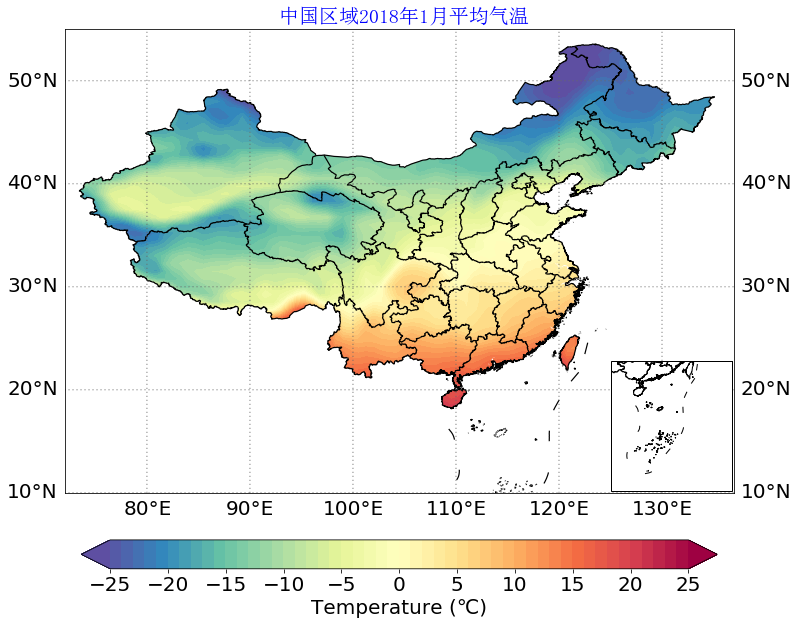

In [23]:
#https://regionmask.readthedocs.io/en/stable/defined_landmask.html
#coding=utf-8
from mpl_toolkits.basemap import Basemap
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import cartopy.crs as ccrs
import shapefile
import xarray as xr
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
import netCDF4 as nc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib
ZHfont = matplotlib.font_manager.FontProperties(fname='/Users/zhpfu/Documents/fonts/SimSun.ttf')

plt.rcParams.update({'font.size':20})


fig = plt.figure(figsize=[12,18]) 
ax = fig.add_subplot(111)



sf = shapefile.Reader("country1")
for shape_rec in sf.shapeRecords():
    if shape_rec.record[2] == 'China':#Hunan Sheng
        vertices = []
        codes = []
        pts = shape_rec.shape.points
        prt = list(shape_rec.shape.parts) + [len(pts)]
        for i in range(len(prt) - 1):
            for j in range(prt[i], prt[i+1]):
                vertices.append((pts[j][0], pts[j][1]))
            codes += [Path.MOVETO]
            codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
            codes += [Path.CLOSEPOLY]
        clip = Path(vertices, codes)
        clip = PathPatch(clip, transform=ax.transData)


        
def makedegreelabel(degreelist):
    labels=[str(x)+u'°E' for x in degreelist]
    return labels


ds = xr.open_dataset('EC-Interim_monthly_2018.nc')
lat = ds.latitude
lon = ds.longitude
data = (ds['t2m'][0,::-1,:] - 273.15) # 把温度转换为℃   [0,::-1,:]表示第一个时次、纬度反向

# ncdata=nc.Dataset('EC-Interim_monthly_2018.nc')
# data=ncdata.variables['t2m'][0,::-1,:] - 273.15 # 把温度转换为℃ 
# lat=ncdata.variables['latitude'][:]
# lon=ncdata.variables['longitude'][:]

nx=data.shape[1]
ny=data.shape[0]
               
m = Basemap(llcrnrlon=72.0,
    llcrnrlat=10.0,
    urcrnrlon=137.0,
    urcrnrlat=55.0,
    resolution = None, 
    projection = 'cyl')


cbar_kwargs = {
    'orientation': 'horizontal',
    'label': 'Temperature (℃)',
    'shrink': 0.02,
    'ticks': np.arange(-25, 25 + 1, 5),
    'pad': -0.28,
    'shrink': 0.95
}


# 画图
levels = np.arange(-25, 25 + 1, 1)   
cs = data.plot.contourf(ax=ax,levels=levels,cbar_kwargs=cbar_kwargs, cmap='Spectral_r')
# 设置标题的在代码中放置的位置很关键，注意不要放置在小图上或者新建画框了。

m.readshapefile('bou2_4l','China Map',color='k',linewidth=1.2)

for contour in cs.collections:
        contour.set_clip_path(clip)

        
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
# http://code.activestate.com/recipes/578399-an-alternative-way-to-draw-parallels-and-meridians/
parallels = np.arange(10,55,10)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,True,True,True],color='dimgrey',dashes=[1, 3])  # ha= 'right'
meridians = np.arange(70,135,10)
m.drawmeridians(meridians,labels=[True,True,False,True],color='dimgrey',dashes=[1, 3])


#http://xarray.pydata.org/en/stable/plotting.html
plt.ylabel('')    #Remove the defult  lat / lon label  
plt.xlabel('')        
           

plt.rcParams.update({'font.size':30})
ax.set_title(u' 中国区域2018年1月平均气温',color='blue',fontsize= 25 ,fontproperties=ZHfont) # 2m Temperature


plt.rcParams.update({'font.size':20})
        
with open('CN-border-La.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]
    
#Plot South China Sea as a subfigure
sub_ax = fig.add_axes([0.758, 0.249, 0.14, 0.155],
                      projection=ccrs.LambertConformal(central_latitude=90,
                                                       central_longitude=115))
# Plot border lines
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', lw=1, color='k',
                transform=ccrs.Geodetic())
# Set figure extent
sub_ax.set_extent([106, 127, 0, 25],crs=ccrs.PlateCarree())        

        
# Save & Show figure
plt.savefig("China_mask_T2m.png", dpi=300, bbox_inches='tight')
plt.show()